### Outline

1. Group Normalisation: BtachNorm was proven effective, but for small batch sizes, vanishing\exploding gradient problem kicks in again. Hence this approach, here, we do not normalise along batch dimension. And if kernel is bigger then stride, which results in overlap and one pixel value gets used all the time for this calculation. Even if there is no overlap, it still poses same challenges.
[Source](https://arxiv.org/abs/1803.08494)
4. GELU: ReLU maps outputs of neurons to zeroes if neurons output negative values. This is called dying relu problem, since no learning occurs for those neurons. Instead GELU offers a more smooth function.
5. Sinusoidal Positional Embeddings: Time is a sequence rather then descrete, if this is not specified to the model then it assumes that noise at time step $t$ might be average of other neighbouring time steps.
6. RearrangePooling: We were using MaxPooling previously, but lot of information gets lost if we do this. Rearrange Pooling, solves this by come complex reshaping by increasing number of channels.  
7. Add more depth: Adding more convolutional layers which increases the depth, ofcourse prone to overfitting.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz
from IPython.display import Image

from utils import other_utils
from utils.ddpm_utils import DDPM

In [106]:
# UTILITY FUNCTIONS

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "data",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_fashionMNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    data = torch.utils.data.ConcatDataset([train_set, test_set])
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

def q(x_0, t):
    """
    q(X_t|X_t-1)
    Samples a new image from distribution q~N(sqrt(1-beta_t) * x_t-1, beta_t)
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = sqrt_alpha_bar[t, None, None, None]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t, None, None, None]

    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise

@torch.no_grad()
def reverse_q(x_t, t, e_t):
    """
    p(X_t-1|X_t)
    """
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        beta_t = beta[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(beta_t) * new_noise

@torch.no_grad()
def plot_images(model, img_ch, img_size, ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = time_steps / ncols

    # Noise to generate images from
    x_t = torch.randn((1, img_ch, img_size, img_size), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, time_steps)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols, plot_number)
            ax.axis('off')
            show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

In [104]:
batch_size = 128
img_size = 16
img_ch = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data, dataloader = load_transformed_fashionMNIST(img_size, batch_size)

In [108]:
# Variational Scheduler = beta
nrows = 10
ncols = 15

time_steps = nrows * ncols
start = 0.0001
end = 0.02

# Forward Diffusion
beta = torch.linspace(start, end, time_steps).to(device)

alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # Mean Coefficient
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar) # St. Dev. Coefficient

# Reverse Diffusion
sqrt_a_inv = torch.sqrt(1 / alpha)
pred_noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)

In [10]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [89]:
# Example of Rearranging

from einops.layers.torch import Rearrange

rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)

test_image = [
    [
        [
            [1, 2, 3, 4, 5, 6],
            [7, 8, 9, 10, 11, 12],
            [13, 14, 15, 16, 17, 18],
            [19, 20, 21, 22, 23, 24],
            [25, 26, 27, 28, 29, 30],
            [31, 32, 33, 34, 35, 36],
        ]
    ]
]
test_image = torch.tensor(test_image)
print(test_image)
output = rearrange(test_image)
output

tensor([[[[ 1,  2,  3,  4,  5,  6],
          [ 7,  8,  9, 10, 11, 12],
          [13, 14, 15, 16, 17, 18],
          [19, 20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35, 36]]]])


tensor([[[[ 1,  3,  5],
          [13, 15, 17],
          [25, 27, 29]],

         [[ 2,  4,  6],
          [14, 16, 18],
          [26, 28, 30]],

         [[ 7,  9, 11],
          [19, 21, 23],
          [31, 33, 35]],

         [[ 8, 10, 12],
          [20, 22, 24],
          [32, 34, 36]]]])

In [90]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [91]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [92]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [93]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [94]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [95]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [96]:
class UNet(nn.Module):
    def __init__(self, img_ch=1, img_size=16):
        super().__init__()
        img_chs = img_ch
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New
        
        
        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New        

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])        
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)        
        down1 = self.down1(down0)        
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)        

        latent_vec = self.dense_emb(latent_vec)
        
        t = t.float() / time_steps  # Convert from [0, time_steps] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

In [97]:
model = UNet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  1979777


In [81]:
@torch.no_grad()
def plot_images(ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = time_steps / ncols
    img_ch = 1
    img_size = 16

    # Noise to generate images from
    x_t = torch.randn((1, img_ch, img_size, img_size), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, time_steps)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols, plot_number)
            ax.axis('off')
            show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

In [ ]:
# Variational Scheduler = beta
nrows = 10
ncols = 15

time_steps = nrows * ncols
start = 0.0001
end = 0.02
beta = torch.linspace(start, end, time_steps).to(device)

alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # Mean Coefficient
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar) # St. Dev. Coefficient

Epoch 1 | step 000 Loss: 0.4063725173473358 


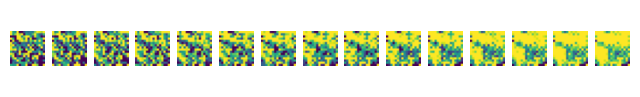

Epoch 1 | step 100 Loss: 0.14830204844474792 


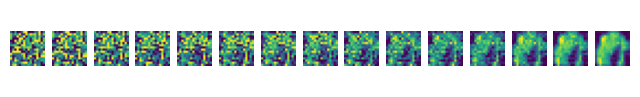

Epoch 1 | step 200 Loss: 0.13978199660778046 


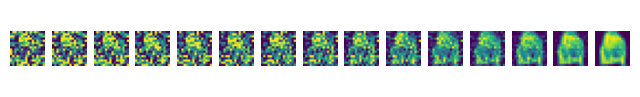

Epoch 1 | step 300 Loss: 0.11137758195400238 


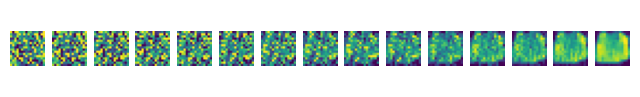

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 1

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, time_steps, (batch_size,), device=device).float()
        x_0 = batch[0].to(device)
        x_noisy, noise = q(x_0, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch+1} | step {step:03d} Loss: {loss.item()} ")
            plot_images(model, img_ch, img_size, ncols, figsize=(8, 1))